In [14]:
import os
import re
import glob
from datetime import datetime
import sys
import itertools
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
sys.path.append("..") # Adds higher directory to python modules path for importing from src dir

from src.algorithms import SimpleLSTM, MLPClassifier, SVC
from src.datasets import NyseStocksDataset
from src.evaluation import Evaluator
from src.preparation import prepare_data
from src.utils import print_metrics_as_md, pandas_df_to_markdown_table
from src.pipeline import run_pipeline, build_pipeline
# from src.experiments import get_metrics

%matplotlib inline
%load_ext autotime
%load_ext autoreload
%autoreload 2

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
time: 212 ms


#### Existing companies

In [45]:
companies = pd.Series(['A', 'AAL', 'AAP', 'AAPL', 'ABBV', 'ABC', 'ABT', 'ACN', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADS', 'ADSK', 'AEE', 'AEP', 'AES', 'AET', 'AFL', 'AGN', 'AIG', 'AIV', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALK', 'ALL', 'ALLE', 'ALXN', 'AMAT', 'AME', 'AMG', 'AMGN', 'AMP', 'AMT', 'AMZN', 'AN', 'ANTM', 'AON', 'APA', 'APC', 'APD', 'APH', 'ARNC', 'ATVI', 'AVB', 'AVGO', 'AVY', 'AWK', 'AXP', 'AYI', 'AZO', 'BA', 'BAC', 'BAX', 'BBBY', 'BBT', 'BBY', 'BCR', 'BDX', 'BEN', 'BHI', 'BIIB', 'BK', 'BLK', 'BLL', 'BMY', 'BSX', 'BWA', 'BXP', 'C', 'CA', 'CAG', 'CAH', 'CAT', 'CB', 'CBG', 'CBS', 'CCI', 'CCL', 'CELG', 'CERN', 'CF', 'CFG', 'CHD', 'CHK', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CLX', 'CMA', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COG', 'COH', 'COL', 'COO', 'COP', 'COST', 'COTY', 'CPB', 'CRM', 'CSCO', 'CSRA', 'CSX', 'CTAS', 'CTL', 'CTSH', 'CTXS', 'CVS', 'CVX', 'CXO', 'D', 'DAL', 'DD', 'DE', 'DFS', 'DG', 'DGX', 'DHI', 'DHR', 'DIS', 'DISCA', 'DISCK', 'DLPH', 'DLR', 'DLTR', 'DNB', 'DOV', 'DOW', 'DPS', 'DRI', 'DTE', 'DUK', 'DVA', 'DVN', 'EA', 'EBAY', 'ECL', 'ED', 'EFX', 'EIX', 'EL', 'EMN', 'EMR', 'ENDP', 'EOG', 'EQIX', 'EQR', 'EQT', 'ES', 'ESRX', 'ESS', 'ETFC', 'ETN', 'ETR', 'EVHC', 'EW', 'EXC', 'EXPD', 'EXPE', 'EXR', 'F', 'FAST', 'FB', 'FBHS', 'FCX', 'FDX', 'FE', 'FFIV', 'FIS', 'FISV', 'FITB', 'FL', 'FLIR', 'FLR', 'FLS', 'FMC', 'FOX', 'FOXA', 'FRT', 'FSLR', 'FTI', 'FTR', 'FTV', 'GD', 'GE', 'GGP', 'GILD', 'GIS', 'GLW', 'GM', 'GOOG', 'GOOGL', 'GPC', 'GPN', 'GPS', 'GRMN', 'GS', 'GT', 'GWW', 'HAL', 'HAR', 'HAS', 'HBAN', 'HBI', 'HCA', 'HCN', 'HCP', 'HD', 'HES', 'HIG', 'HOG', 'HOLX', 'HON', 'HP', 'HPE', 'HPQ', 'HRB', 'HRL', 'HRS', 'HSIC', 'HST', 'HSY', 'HUM', 'IBM', 'ICE', 'IDXX', 'IFF', 'ILMN', 'INTC', 'INTU', 'IP', 'IPG', 'IR', 'IRM', 'ISRG', 'ITW', 'IVZ', 'JBHT', 'JCI', 'JEC', 'JNJ', 'JNPR', 'JPM', 'JWN', 'K', 'KEY', 'KHC', 'KIM', 'KLAC', 'KMB', 'KMI', 'KMX', 'KO', 'KORS', 'KR', 'KSS', 'KSU', 'L', 'LB', 'LEG', 'LEN', 'LH', 'LKQ', 'LLL', 'LLTC', 'LLY', 'LMT', 'LNC', 'LNT', 'LOW', 'LRCX', 'LUK', 'LUV', 'LVLT', 'LYB', 'M', 'MA', 'MAA', 'MAC', 'MAR', 'MAS', 'MAT', 'MCD', 'MCHP', 'MCK', 'MCO', 'MDLZ', 'MDT', 'MET', 'MHK', 'MJN', 'MKC', 'MLM', 'MMC', 'MMM', 'MNK', 'MNST', 'MO', 'MON', 'MOS', 'MPC', 'MRK', 'MRO', 'MSFT', 'MSI', 'MTB', 'MTD', 'MU', 'MUR', 'MYL', 'NAVI', 'NBL', 'NDAQ', 'NEE', 'NEM', 'NFLX', 'NFX', 'NI', 'NKE', 'NLSN', 'NOC', 'NOV', 'NRG', 'NSC', 'NTAP', 'NTRS', 'NUE', 'NVDA', 'NWL', 'NWS', 'NWSA', 'O', 'OKE', 'OMC', 'ORCL', 'ORLY', 'OXY', 'PAYX', 'PBCT', 'PBI', 'PCAR', 'PCG', 'PCLN', 'PDCO', 'PEG', 'PEP', 'PFE', 'PFG', 'PG', 'PGR', 'PH', 'PHM', 'PKI', 'PLD', 'PM', 'PNC', 'PNR', 'PNW', 'PPG', 'PPL', 'PRGO', 'PRU', 'PSA', 'PSX', 'PVH', 'PWR', 'PX', 'PXD', 'PYPL', 'QCOM', 'QRVO', 'R', 'RAI', 'RCL', 'REGN', 'RF', 'RHI', 'RHT', 'RIG', 'RL', 'ROK', 'ROP', 'ROST', 'RRC', 'RSG', 'RTN', 'SBUX', 'SCG', 'SCHW', 'SE', 'SEE', 'SHW', 'SIG', 'SJM', 'SLB', 'SLG', 'SNA', 'SNI', 'SO', 'SPG', 'SPGI', 'SPLS', 'SRCL', 'SRE', 'STI', 'STT', 'STX', 'STZ', 'SWK', 'SWKS', 'SWN', 'SYF', 'SYK', 'SYMC', 'SYY', 'T', 'TAP', 'TDC', 'TDG', 'TEL', 'TGNA', 'TGT', 'TIF', 'TJX', 'TMK', 'TMO', 'TRIP', 'TROW', 'TRV', 'TSCO', 'TSN', 'TSO', 'TSS', 'TWX', 'TXN', 'TXT', 'UAA', 'UAL', 'UDR', 'UHS', 'ULTA', 'UNH', 'UNM', 'UNP', 'UPS', 'URBN', 'URI', 'USB', 'UTX', 'V', 'VAR', 'VFC', 'VIAB', 'VLO', 'VMC', 'VNO', 'VRSK', 'VRSN', 'VRTX', 'VTR', 'VZ', 'WAT', 'WBA', 'WDC', 'WEC', 'WFC', 'WFM', 'WHR', 'WLTW', 'WM', 'WMB', 'WMT', 'WRK', 'WU', 'WY', 'WYN', 'WYNN', 'XEC', 'XEL', 'XL', 'XLNX', 'XOM', 'XRAY', 'XRX', 'XYL', 'YHOO', 'YUM', 'ZBH', 'ZION', 'ZTS'])
companies[19::20] = ['\n'+x for x in companies[19::20]]
print('  '.join(companies))

A  AAL  AAP  AAPL  ABBV  ABC  ABT  ACN  ADBE  ADI  ADM  ADP  ADS  ADSK  AEE  AEP  AES  AET  AFL  
AGN  AIG  AIV  AIZ  AJG  AKAM  ALB  ALK  ALL  ALLE  ALXN  AMAT  AME  AMG  AMGN  AMP  AMT  AMZN  AN  ANTM  
AON  APA  APC  APD  APH  ARNC  ATVI  AVB  AVGO  AVY  AWK  AXP  AYI  AZO  BA  BAC  BAX  BBBY  BBT  BBY  
BCR  BDX  BEN  BHI  BIIB  BK  BLK  BLL  BMY  BSX  BWA  BXP  C  CA  CAG  CAH  CAT  CB  CBG  CBS  
CCI  CCL  CELG  CERN  CF  CFG  CHD  CHK  CHRW  CHTR  CI  CINF  CL  CLX  CMA  CMCSA  CME  CMG  CMI  CMS  
CNC  CNP  COF  COG  COH  COL  COO  COP  COST  COTY  CPB  CRM  CSCO  CSRA  CSX  CTAS  CTL  CTSH  CTXS  CVS  
CVX  CXO  D  DAL  DD  DE  DFS  DG  DGX  DHI  DHR  DIS  DISCA  DISCK  DLPH  DLR  DLTR  DNB  DOV  DOW  
DPS  DRI  DTE  DUK  DVA  DVN  EA  EBAY  ECL  ED  EFX  EIX  EL  EMN  EMR  ENDP  EOG  EQIX  EQR  EQT  
ES  ESRX  ESS  ETFC  ETN  ETR  EVHC  EW  EXC  EXPD  EXPE  EXR  F  FAST  FB  FBHS  FCX  FDX  FE  FFIV  
FIS  FISV  FITB  FL  FLIR  FLR  FLS  FMC  FOX  FOXA  FRT  FSLR  FTI  FTR  F

In [48]:
ds = NyseStocksDataset('OC-3C', file_path='../data/nyse/prices.csv', companies=['GOOGL', 'GOOG', 'AMZN', 'APC'])
ds.load();


time: 2.75 s


In [73]:
X_train, y_train, X_test, y_test = ds.data()
pdata = prepare_data(ds, train_size = 45000, test_size = 4500, downsample=True)

time: 245 ms


In [74]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print(X_train.date.min(), 'to', X_train.date.max())
X_train.head()

(6012, 16) (6012,) (1008, 16) (1008,)
2010-01-13 00:00:00 to 2015-12-31 00:00:00


day           date symbol       day_1                   day_2              \
feature                             O           C           O           C   
3559    2010-01-13   AMZN  128.990005  127.349998  132.619995  130.309998   
3564    2010-01-13    APC   65.650002   64.139999   67.580002   66.309998   
3715    2010-01-13   GOOG  597.651011  590.481036  604.461060  601.111020   
3716    2010-01-13  GOOGL  597.649989  590.479981  604.460006  601.110027   
4027    2010-01-14   AMZN  127.900002  129.110001  128.990005  127.349998   

day           day_3                   day_4                   day_5  \
feature           O           C           O           C           O   
3559     130.559998  133.520004  132.009995  130.000000  134.600006   
3564      66.709999   67.059998   66.860001   67.029999   66.839996   
3715     592.000997  602.021036  609.401025  594.101005  625.861078   
3716     592.000005  602.020005  609.400008  594.100015  625.860033   
4027     132.619995  130.309998  130.559998  133.520004  132.009995   

day                       day_6                   day_7              
feature           C           O           C           O           C  
3559     132.250000  133.429993  134.690002  136.250000  133.899994  
3564      67.139999   65.160004   66.559998   63.599998   64.739998  
3715     608.261023  627.181073  623.991055  626.951088  626.751061  
3716     608.260035  627.180001  623.990017  626.950006  626.750011  
4027     130.000000  134.600006  132.250000  133.429993  134.690002

time: 262 ms


In [75]:
print(*[x.shape for x in pdata])
pdata[0].head()

(2020, 14) (2020,) (336, 14) (336,)


day           day_1                   day_2                   day_3  \
feature           O           C           O           C           O   
3559     128.990005  127.349998  132.619995  130.309998  130.559998   
3564      65.650002   64.139999   67.580002   66.309998   66.709999   
3715     597.651011  590.481036  604.461060  601.111020  592.000997   
3716     597.649989  590.479981  604.460006  601.110027  592.000005   
4027     127.900002  129.110001  128.990005  127.349998  132.619995   

day                       day_4                   day_5              \
feature           C           O           C           O           C   
3559     133.520004  132.009995  130.000000  134.600006  132.250000   
3564      67.059998   66.860001   67.029999   66.839996   67.139999   
3715     602.021036  609.401025  594.101005  625.861078  608.261023   
3716     602.020005  609.400008  594.100015  625.860033  608.260035   
4027     130.309998  130.559998  133.520004  132.009995  130.000000   

day           day_6                   day_7              
feature           O           C           O           C  
3559     133.429993  134.690002  136.250000  133.899994  
3564      65.160004   66.559998   63.599998   64.739998  
3715     627.181073  623.991055  626.951088  626.751061  
3716     627.180001  623.990017  626.950006  626.750011  
4027     134.600006  132.250000  133.429993  134.690002

time: 251 ms


In [87]:
_predictor = MLPClassifier()
pipeline = build_pipeline(_predictor, pdata)

def pipeline_transform(X, fit=False):
    X = pipeline.steps[0][1].transform(X)
    if fit:
        pipeline.steps[1][1].fit(X)
    X = pipeline.steps[1][1].transform(X)
    # https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#robustscaler
    return pipeline.steps[2][1].transform(X)

pX_train = pipeline_transform(pdata[0], fit=True)
pX_test = pipeline_transform(pdata[2])
pd.DataFrame(pX_train).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-0.899992,-0.905677,-0.892749,-0.893092,-0.901034,-0.890047,-0.894937,-0.900592,-0.889163,-0.892686,-0.891912,-0.885386,-0.882329,-0.885267
1,-1.042237,-1.048083,-1.039324,-1.036654,-1.045155,-1.039485,-1.041894,-1.042400,-1.042162,-1.039353,-1.046152,-1.039055,-1.045794,-1.041076
2,0.152498,0.137710,0.170600,0.162989,0.140522,0.163391,0.181898,0.144556,0.220085,0.179579,0.223600,0.218246,0.221765,0.225063
3,0.152496,0.137707,0.170598,0.162987,0.140520,0.163388,0.181896,0.144554,0.220082,0.179577,0.223598,0.218244,0.221762,0.225061
4,-0.902440,-0.901712,-0.900930,-0.899731,-0.896384,-0.897265,-0.898208,-0.892665,-0.895011,-0.897755,-0.889268,-0.890889,-0.888674,-0.883487


time: 1.19 s


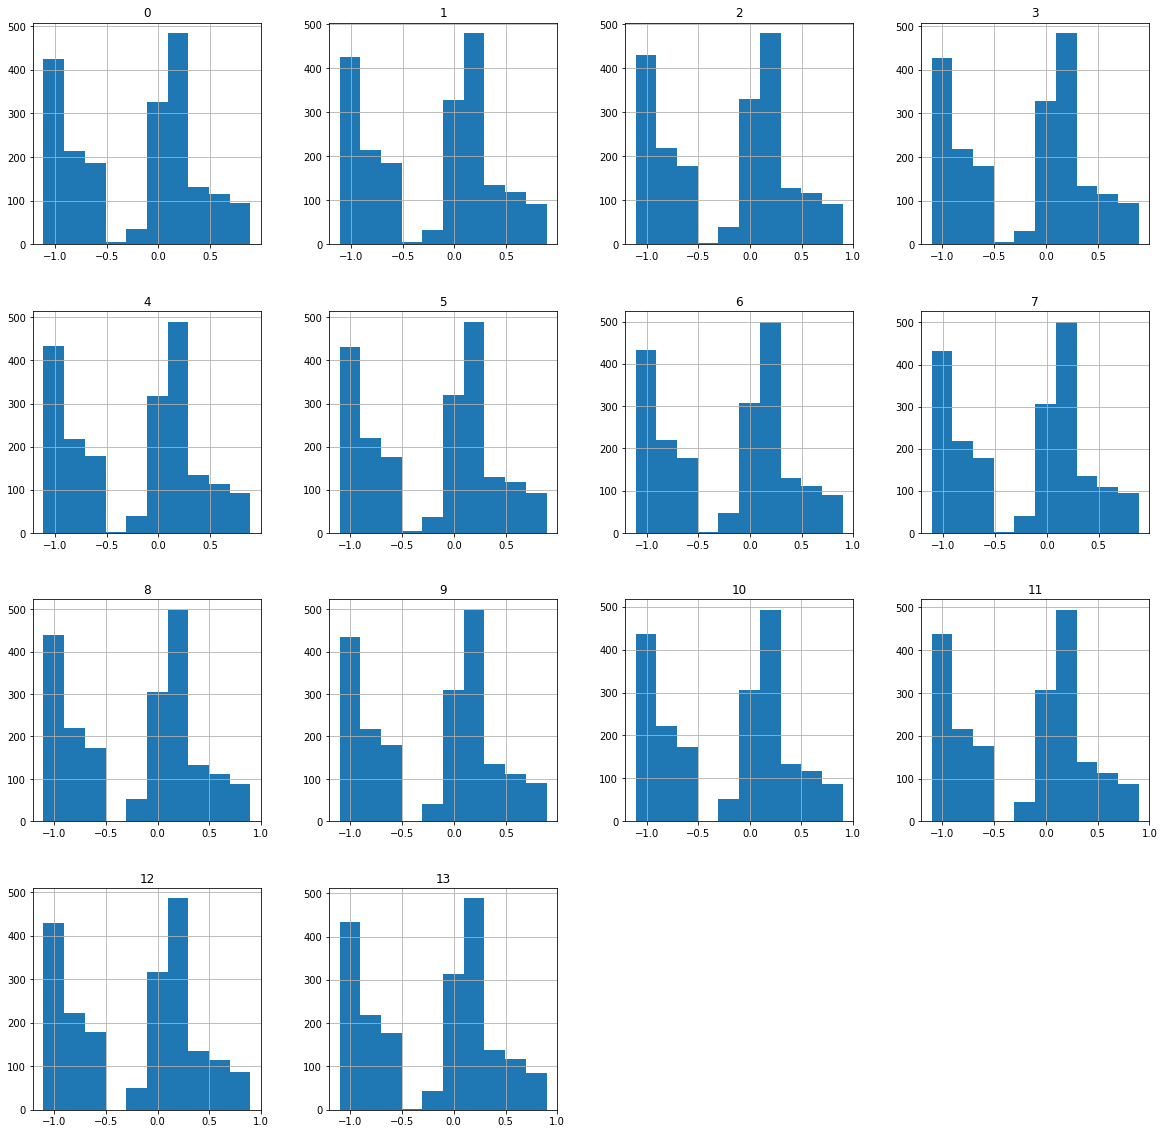

time: 14.6 s


In [90]:
pd.DataFrame(pX_train).hist(figsize=(20, 20))
# plt.gcf().savefig('plots/features-scaling.png')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F3354FC5C0>,
      dtype=object)

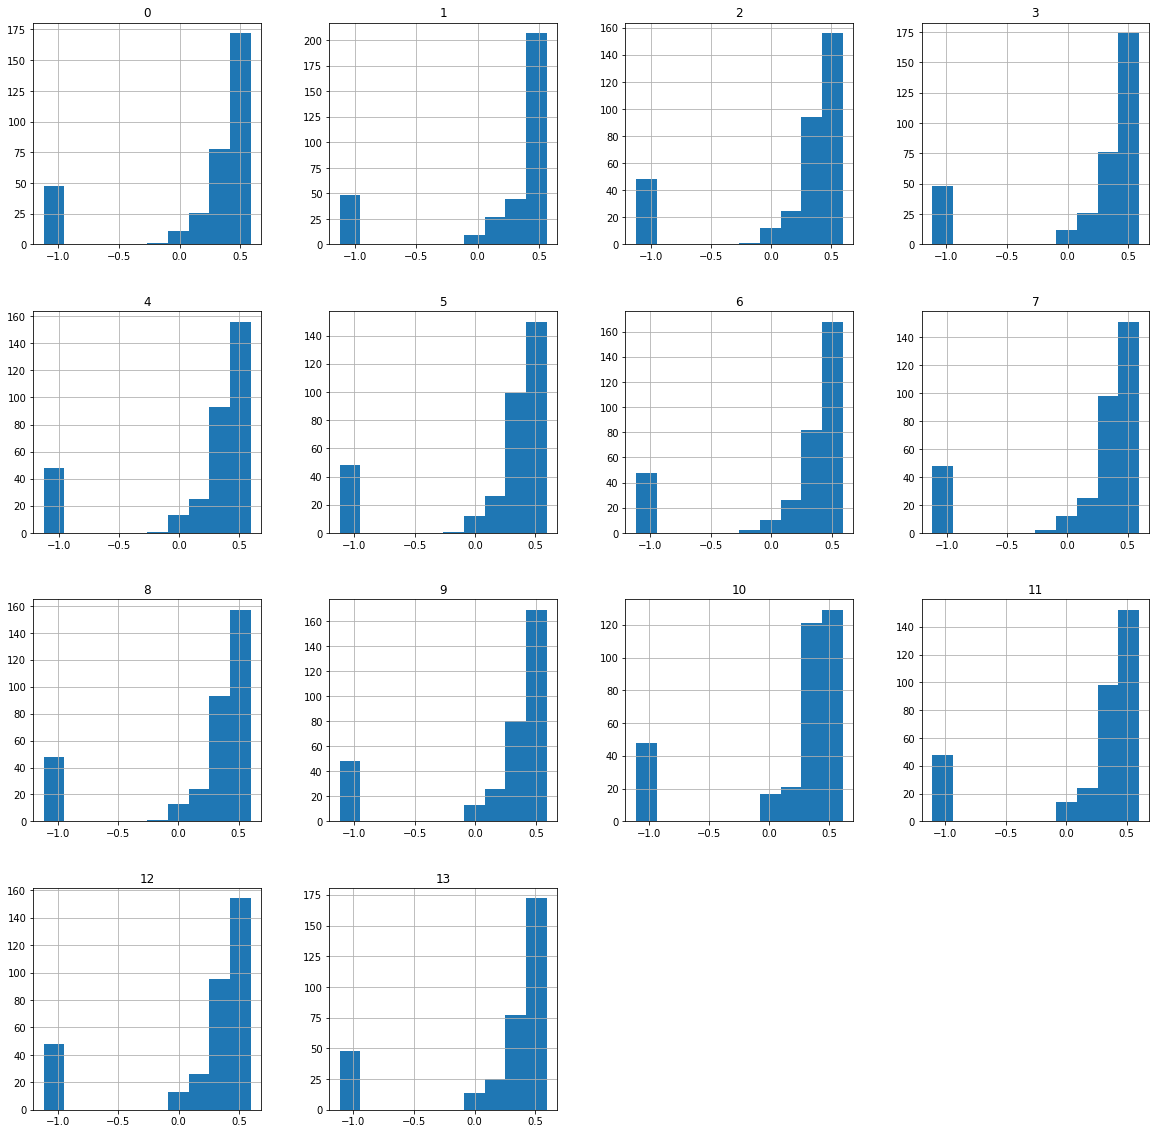

time: 14.6 s


In [91]:
pd.DataFrame(pX_test).hist(figsize=(20, 20))
plt.gcf().savefig('plots/features-scaling.png')

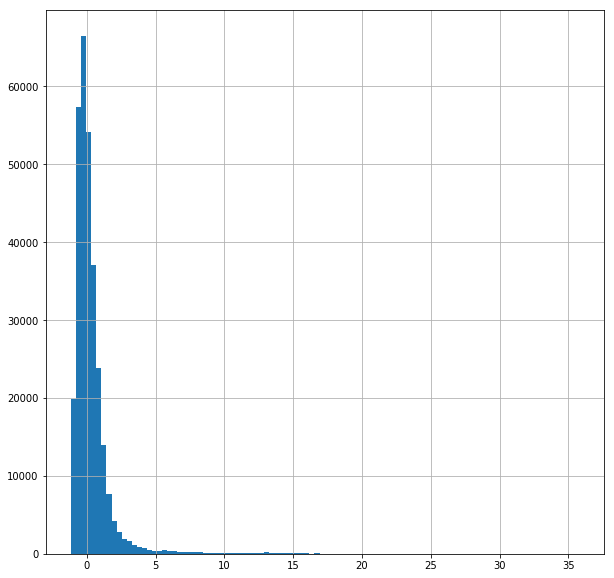

time: 4.08 s


In [99]:
ds2 = NyseStocksDataset('OC-3C', file_path='../data/nyse/prices.csv')
ds2.load()

pdata2 = prepare_data(ds2, 300000, 30000)
pX_train2 = pipeline_transform(pdata2[0], fit=True)
pX_test2 = pipeline_transform(pdata2[2])

pd.DataFrame(pX_train2).iloc[:, 0].hist(figsize=(10, 10), bins=100)
plt.gcf().savefig('day-7-open-after-robust-scaling.png')